# _(Wang & Buzsáki, 1996)_ Gamma Oscillation

Here we show the implementation of gamma oscillation proposed by Xiao-Jing Wang and György Buzsáki (1996). They demonstrated that the GABA$_A$ synaptic transmission provides a suitable mechanism for synchronized gamma oscillations in a network of fast-spiking interneurons. 

Let's first import brainpy and set profiles.

In [1]:
import brainpy as bp
import brainpy.math as bm

bp.math.set_dt(0.05)

The network is constructed with Hodgkin–Huxley (HH) type neurons and GABA$_A$ synapses. 

The dynamics of the HH type neurons is given by:

$$ C \frac {dV} {dt} = -(I_{Na} + I_{K} + I_L) + I(t) $$

where $I(t)$ is the injected current, the leak current $ I_L = g_L (V - E_L) $, and the transient sodium current 

$$ I_{Na} = g_{Na} m_{\infty}^3 h (V - E_{Na}) $$

where the activation variable $m$ is assumed fast and substituted by its steady-state function 
$m_{\infty} = \alpha_m / (\alpha_m + \beta_m)$.
And the inactivation variable $h$ obeys a first=order kinetics:
$$ \frac {dh} {dt} = \phi (\alpha_h (1-h) - \beta_h h)$$

$$ I_K = g_K n^4 (V - E_K) $$

where the activation variable $n$ also obeys a first=order kinetics:
$$ \frac {dn} {dt} = \phi (\alpha_n (1-n) - \beta_n n)$$

In [2]:
class HH(bp.dyn.NeuGroup):
  def __init__(self, size, ENa=55., EK=-90., EL=-65, C=1.0, gNa=35.,
               gK=9., gL=0.1, V_th=20., phi=5.0, method='exp_auto'):
    super(HH, self).__init__(size=size)

    # parameters
    self.ENa = ENa
    self.EK = EK
    self.EL = EL
    self.C = C
    self.gNa = gNa
    self.gK = gK
    self.gL = gL
    self.V_th = V_th
    self.phi = phi

    # variables
    self.V = bm.Variable(bm.ones(size) * -65.)
    self.h = bm.Variable(bm.ones(size) * 0.6)
    self.n = bm.Variable(bm.ones(size) * 0.32)
    self.spike = bm.Variable(bm.zeros(size, dtype=bool))
    self.input = bm.Variable(bm.zeros(size))
    self.t_last_spike = bm.Variable(bm.ones(size) * -1e7)

    # integral
    self.integral = bp.odeint(bp.JointEq([self.dV, self.dh, self.dn]), method=method)

  def dh(self, h, t, V):
    alpha = 0.07 * bm.exp(-(V + 58) / 20)
    beta = 1 / (bm.exp(-0.1 * (V + 28)) + 1)
    dhdt = alpha * (1 - h) - beta * h
    return self.phi * dhdt

  def dn(self, n, t, V):
    alpha = -0.01 * (V + 34) / (bm.exp(-0.1 * (V + 34)) - 1)
    beta = 0.125 * bm.exp(-(V + 44) / 80)
    dndt = alpha * (1 - n) - beta * n
    return self.phi * dndt

  def dV(self, V, t, h, n, Iext):
    m_alpha = -0.1 * (V + 35) / (bm.exp(-0.1 * (V + 35)) - 1)
    m_beta = 4 * bm.exp(-(V + 60) / 18)
    m = m_alpha / (m_alpha + m_beta)
    INa = self.gNa * m ** 3 * h * (V - self.ENa)
    IK = self.gK * n ** 4 * (V - self.EK)
    IL = self.gL * (V - self.EL)
    dVdt = (- INa - IK - IL + Iext) / self.C

    return dVdt

  def update(self, _t, _dt):
    V, h, n = self.integral(self.V, self.h, self.n, _t, self.input, _dt)
    self.spike.value = bm.logical_and(self.V < self.V_th, V >= self.V_th)
    self.t_last_spike.value = bm.where(self.spike, _t, self.t_last_spike)
    self.V.value = V
    self.h.value = h
    self.n.value = n
    self.input[:] = 0.

Let's run a simulation of a network with 100 neurons with constant inputs (1 $\mu$A/cm$^2$).

In [3]:
num = 100
neu = HH(num)
neu.V[:] = -70. + bm.random.normal(size=num) * 20

syn = bp.dyn.GABAa(pre=neu, post=neu, conn=bp.connect.All2All(include_self=False))
syn.g_max = 0.1 / num

net = bp.dyn.Network(neu=neu, syn=syn)
runner = bp.dyn.DSRunner(net, monitors=['neu.spike', 'neu.V'], inputs=['neu.input', 1.])
runner.run(duration=500.)

  0%|          | 0/10000 [00:00<?, ?it/s]

0.6891062259674072

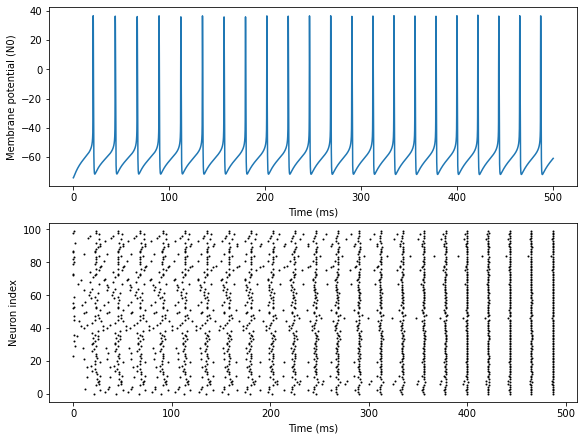

In [4]:
fig, gs = bp.visualize.get_figure(2, 1, 3, 8)

fig.add_subplot(gs[0, 0])
bp.visualize.line_plot(runner.mon.ts, runner.mon['neu.V'], ylabel='Membrane potential (N0)')

fig.add_subplot(gs[1, 0])
bp.visualize.raster_plot(runner.mon.ts, runner.mon['neu.spike'], show=True)

We can see the result of this simulation that cells starting at random and asynchronous initial conditions quickly become synchronized and their spiking times are perfectly in-phase within 5-6 oscillatory cycles.

**Reference**:

- Wang, Xiao-Jing, and György Buzsáki. “Gamma oscillation by synaptic inhibition in a hippocampal interneuronal network model.” Journal of neuroscience 16.20 (1996): 6402-6413.